In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from energyflow.archs import EFN
from energyflow.utils import data_split

2023-08-30 04:21:21.840309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def read_data(file_path):
    data_file = open(file_path)
    lno = 0
    pTvals = []
    etavals = []
    phivals = []
    tvals = []
    events_input=[]
    events_target=[]
    data = []

    for line in data_file:
        lno+=1
        if (lno > 1000000000):
            break
        # enumber = int(line.split()[0])
        isprime = int(line.split()[1])
        E = float(line.split()[2])
        px = float(line.split()[3])
        py = float(line.split()[4])
        pz = float(line.split()[5])
        t = float(line.split()[6])
        
        pT = math.sqrt( px**2 + py**2 )
        p = math.sqrt( px**2 + py**2 + pz**2 )
        
        if (pz > 0):    
            eta = math.acosh(p / pT)
        else:
            eta = -math.acosh(p / pT)
        phi = math.atan( py / px )
        
        if (isprime==1):
            pTvals += [pT]
            etavals += [eta]
            phivals += [phi]
            tvals += [t]
            data += [[pT,eta,phi,t]]
        if (isprime==0):
            events_target += [[t]] 
            if (lno > 1):
                events_input += [data]
            data=[]

    events_input += [data]

    return events_input, events_target



In [3]:
def zero_padding(raw_data, max_num):

    input_zp = np.zeros([max_num,40,4])

    for i in range(0, max_num):
        for j in range(min(40,len(raw_data[i]))):
            input_zp[i,j,:] = raw_data[i][j]
        # np.random.shuffle(input_zp[i,:,:])

    return input_zp

In [4]:
def normalization(input, target, max_num):

    pT_weighted_time = []

    for jet in input:
        mask = jet[:,0] > 0
        yphi_avg = np.average(jet[mask,1:3], weights=jet[mask,0], axis=0)
        jet[mask,1:3] -= yphi_avg
        
        t_avg = np.average(jet[mask,3], weights=jet[mask,0], axis=0)
        pT_weighted_time += [[t_avg]]
        jet[mask,3] /= t_avg
        jet[mask,3] -= 1
        jet[mask,0] /= jet[:,0].sum()

    target = np.array(target[:max_num])
    target_scaled = target / pT_weighted_time - 1

    return pT_weighted_time, input, target_scaled

In [5]:
def preprocessing(input_path_list, max_num):

    data_input_dict = {}
    data_label_dict = {}
    data_pTweighted_dict = {}

    for key, data_path in enumerate(input_path_list):
        
        raw_input, raw_label = read_data(data_path)
        input_zp = zero_padding(raw_input, max_num)
        pTweighted_time, input_scaled, label_scaled = normalization(input_zp, raw_label, max_num)

        data_input_dict["input"+data_path] = input_scaled
        data_label_dict["label"+data_path] = label_scaled
        data_pTweighted_dict["pTweighted"+data_path] = pTweighted_time

    return data_pTweighted_dict, data_input_dict, data_label_dict

In [6]:
num_jets =30000 

input_path_list = ['/root/jettiming/data/jet_time_data_xt_05_etaM_0_etaJ_-2.txt']
pTweighted_dict, input_dict, label_dict = preprocessing(input_path_list, num_jets)

In [7]:
import tensorflow as tf
from keras import backend as K

efn = tf.keras.models.load_model('/root/jettiming/code/trained_model/mixed_efn_latent200_2config.h5', custom_objects={"K": K})

2023-08-30 04:21:33.609292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 04:21:33.613970: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [66]:
features_name = []

for i in range(40):
    constituent_f = [f'pT_{i}', f'eta_{i}', f'phi_{i}', f't_{i}']
    features_name.extend(constituent_f)

In [85]:
num_avg = 50

train_set = input_dict['input/root/jettiming/data/jet_time_data_xt_05_etaM_0_etaJ_-2.txt']
label_set = label_dict['label/root/jettiming/data/jet_time_data_xt_05_etaM_0_etaJ_-2.txt']
# Split the mixed data. The shuffle take place before splitting.

input_data = train_set[:num_avg,:,:]

pre_jet = [input_data[i].flatten() for i in range(len(input_data)) ]

In [86]:
import pandas as pd

avg_df = pd.DataFrame(pre_jet)
avg_df.columns = features_name
print(avg_df)

        pT_0     eta_0     phi_0       t_0      pT_1     eta_1     phi_1  \
0   0.332821  0.069673  0.039596 -0.048595  0.138852  0.062950  0.030482   
1   0.363927 -0.128804  0.048093  0.072159  0.139912 -0.162022  0.032575   
2   0.378559  0.087846  0.015348 -0.054496  0.121042 -0.101786 -0.027534   
3   0.387097 -0.002340 -0.038891  0.000327  0.172979 -0.010402 -0.032106   
4   0.269632  0.030598 -0.035930 -0.026179  0.108982  0.138041 -0.014612   
5   0.320155 -0.035118 -0.091975  0.019995  0.306746  0.070894  0.164579   
6   0.335652 -0.020397 -0.100556  0.010054  0.153274  0.022418  0.217834   
7   0.312658  0.028335  0.055652 -0.023939  0.135763 -0.256621  0.030843   
8   0.329794 -0.032743 -0.044649  0.018869  0.161836 -0.042643 -0.037070   
9   0.297768  0.001558 -0.012655 -0.003462  0.254303  0.018018 -0.014427   
10  0.349624 -0.042644  0.020246  0.024600  0.182390  0.045197 -0.082526   
11  0.484098  0.001975 -0.023142 -0.002722  0.126242 -0.005986 -0.028339   
12  0.335329

In [68]:
def warpped_pred(df):
    
    prediction = []
    
    df = np.array(df)
    dfa = df.reshape([len(df),40,4])
    input_z = dfa[:,:,0]
    input_X = dfa[:,:,1:]
    prediction = efn.predict([input_z, input_X])

    return prediction

In [87]:
import shap

explainer = shap.KernelExplainer(warpped_pred, avg_df)

2/2 [==============================] - 0s 34ms/step


In [92]:
start_index = 1688
num_eva = 1

eva = np.array(train_set[start_index: (start_index + num_eva)])
e_pre_jet = eva.reshape([num_eva, 160])
edf = pd.DataFrame(e_pre_jet)
edf.columns = features_name
# print(e_pre_jet)
print(edf)

       pT_0     eta_0     phi_0       t_0      pT_1     eta_1     phi_1  \
0  0.497099  0.008333 -0.028533 -0.006737  0.141271 -0.009111 -0.028866   

        t_1      pT_2     eta_2  ...  phi_37  t_37  pT_38  eta_38  phi_38  \
0  0.004339  0.092003 -0.098667  ...     0.0   0.0    0.0     0.0     0.0   

   t_38  pT_39  eta_39  phi_39  t_39  
0   0.0    0.0     0.0     0.0   0.0  

[1 rows x 160 columns]


In [93]:
shap_values = explainer.shap_values(edf, nsamples=500)

# warpped_pred(edf)

  0%|          | 0/1 [00:00<?, ?it/s]

782/782 [==============================] - 71s 91ms/step


In [94]:
print(eva)

[[[ 0.4970986   0.00833345 -0.02853304 -0.00673684]
  [ 0.1412705  -0.00911065 -0.02886552  0.00433875]
  [ 0.0920033  -0.09866748  0.11851189  0.06367249]
  [ 0.06265993  0.09039064  0.05359494 -0.05696421]
  [ 0.04843038 -0.04056728  0.00724985  0.02448917]
  [ 0.0426833  -0.0109439  -0.04214089  0.00564076]
  [ 0.02234539  0.08464173  0.06541415 -0.05348414]
  [ 0.0219608   0.09159354  0.09798532 -0.05773367]
  [ 0.01292848  0.07459193  0.00478095 -0.04742923]
  [ 0.01134359 -0.01999902  0.05764541  0.01081523]
  [ 0.00851273  0.14237323  0.16647245 -0.08633088]
  [ 0.00845824 -0.26094475 -0.15146508  0.18805045]
  [ 0.00695614 -0.33860469 -0.01480935  0.25246865]
  [ 0.006191    0.14083332  0.17246993 -0.08543647]
  [ 0.00533322 -0.32320882  0.30795693  0.2408399 ]
  [ 0.00447507  0.24212681  0.18942331 -0.13694363]
  [ 0.00427986  0.23071315 -0.4307209  -0.12031695]
  [ 0.00306948  0.15680017 -0.20499434 -0.08655054]
  [ 0.          0.          0.          0.        ]
  [ 0.      

In [95]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0], edf, features_name, contribution_threshold=0.05)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


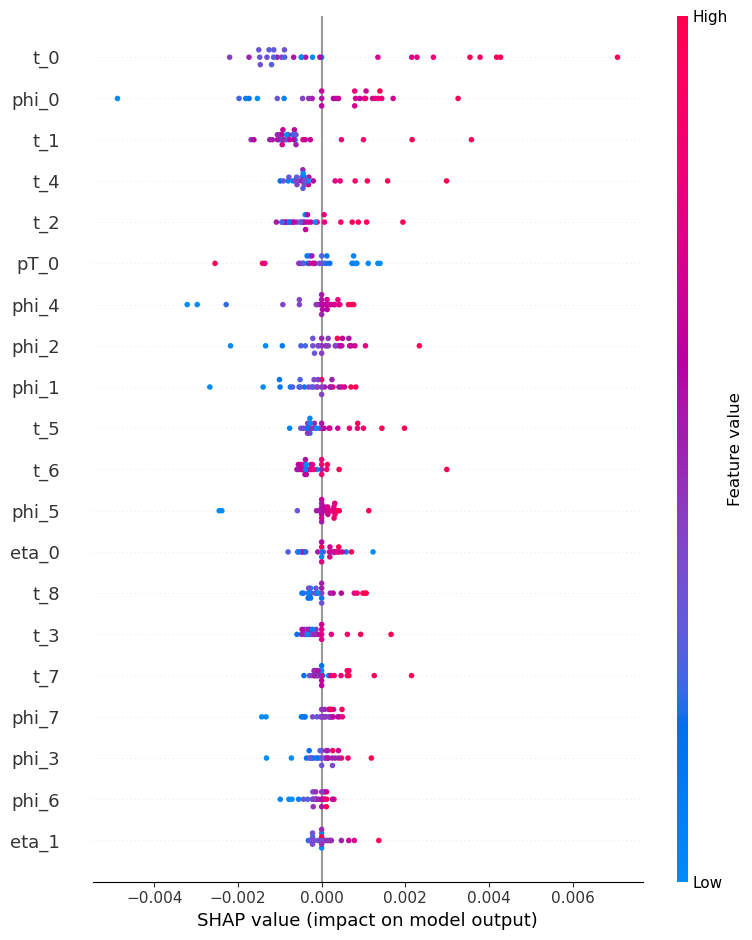

In [17]:
# shap.summary_plot(shap_values[0], edf, features_name, max_display=20)

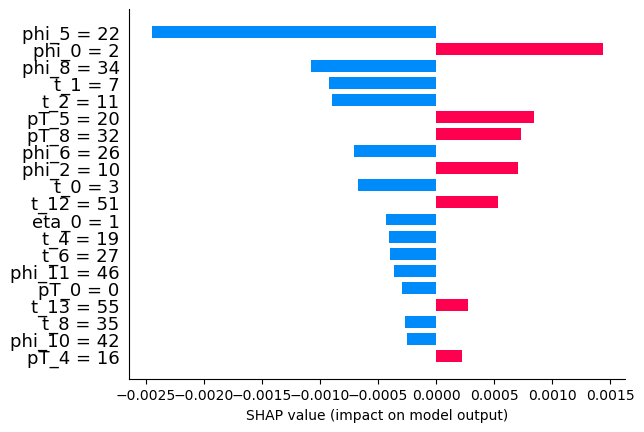

In [18]:
import shap

shap.bar_plot(shap_values[0][1], edf, features_name, max_display=20)

In [ ]:
# shapvalues = explainer(edf)

  0%|          | 0/20 [00:00<?, ?it/s]

1435/1435 [==============================] - 22s 15ms/step


In [ ]:
# shap.plots.scatter(shapvalues[:, "t_0"])

In [82]:
# nk_explainer = shap.Explainer(warpped_pred)

# nk_int_shap_values = nk_explainer.(edf)

AttributeError: 'Permutation' object has no attribute 'shap_interaction_values'